In [1]:
# from google.colab import drive
# drive.mount("/content/drive")
# DRIVE_SRC = "/content/drive/MyDrive/IIT-Projects/third-umpire-decision-automation/backend/experiments/src"
# !rm -r -f ./sample_data
# !cp -r /content/drive/MyDrive/IIT-Projects/third-umpire-decision-automation/.creds/.aws ~/
# !cp -r $DRIVE_SRC ./src

In [2]:
# ! pip install -qq sagemaker

In [3]:
# TODO in the augmented dataset
# 1. Filter out the small bounding boxes
# 2. Split correctly
# 3. There are some images without segmentations

In [4]:
# !rm -r /content/data/cricket-semantic-segmentation

In [1]:
import sys, os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

from typing import Tuple
import os, shutil
from tqdm.auto import tqdm
import cv2 as cv
from src.data.generate import kaggleDS2NativeDS
import numpy as np

kaggleDS2NativeDS("../data/Cricket-Semantic-Segmentation", "../data/Cricket-Semantic-Segmentation[Native]")

---- Creating Bounding Boxes ----


  0%|          | 0/298 [00:00<?, ?it/s]

In [3]:
import sys, os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

import os, shutil
# from src.data.download import download
from src.data.generate import segmentationDS2DetectionDS

# # download_dir = download("cricket-semantic")
download_dir = "../data/Cricket-Semantic-Segmentation-batsmens-copy"
# segmentationDS2DetectionDS(download_dir)
# seg_dir = f"{download_dir}/segmentation-images"
# os.makedirs(seg_dir)
# src_img_dir = f"{download_dir}/images"
# src_seg_names = list(filter(lambda nm: "___fuse" in nm, os.listdir(src_img_dir)))
# for src_seg_name in src_seg_names:
#     dst_seg_name = src_seg_name[:-11]
#     src_seg_path = f"{src_img_dir}/{src_seg_name}"
#     dst_seg_path = f"{seg_dir}/{dst_seg_name}"
#     shutil.move(src_seg_path, dst_seg_path)

# imp_fil_names = list(filter(lambda nm: "___" in nm, os.listdir(src_img_dir)))
# for imp_fil_nm in imp_fil_names:
#     imp_fil_path = f"{src_img_dir}/{imp_fil_nm}"
#     os.remove(imp_fil_path)

In [5]:

from src.data.generate import makeDarknetSegmentationDataset
from src.data.io import readClassesFile

context_classes = ["Batsmen", "Ball", "Wicket", "Bowler", "Wicket Keeper", "Umpire", "Fielder"]
dataset_classes = ["Batsmen"]
export_path = "../data/Batsmen-Semantic-Segmentation"

makeDarknetSegmentationDataset(
    download_dir,
    context_classes,
    dataset_classes,
    export_path,
    split_weights=[7,2],
    ds_name="batsmen-semantic-segmentation"
)

---- Generatinig dataset ----


  0%|          | 0/298 [00:00<?, ?it/s]

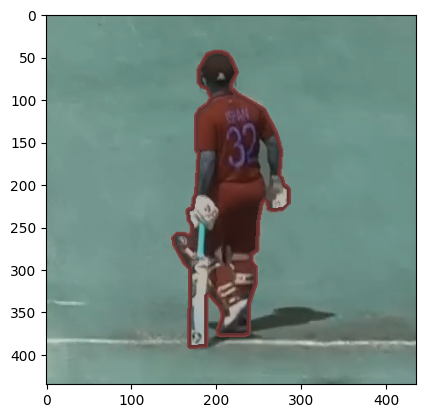

In [7]:
import cv2 as cv
import matplotlib.pyplot as plt
from src.data.visualize import drawSegments

txt_path = f"{export_path}/segmentations/000000.txt"
img_path = f"{export_path}/images/000000.png"
with open(txt_path) as handler:
  txt = handler.read()
img = cv.imread(img_path)
plt.imshow(drawSegments(img, txt))

In [8]:
# zip_path = shutil.make_archive("batsmen-semantic-segmentation", "zip", splited_path)

In [9]:
# from sagemaker.s3 import S3Uploader
# dst_ds_uri = "s3://third-umpire-decision-automation-osura/datasets"
# S3Uploader.upload(zip_path, dst_ds_uri)

# Augment data

In [8]:
splited_path = "../data/Batsmen-Semantic-Segmentation[splitted]"
augment_data_path = "../data/Batsmen-Semantic-Segmentation[augmented]"

In [9]:
# images that has batsmen in the expected poses
emphasis_nums = [2,3,4,5,8,10,14,16,27,30,36,42,43,45,60,64,68,72,79,82,100,102,104,108,115,117,120,121,126,132,140,141,160,164,170,175,181,185,197,199,209,213,216,236,246,264,272,273,296,313,318,324,330,352,368,369,376,379,389,402,404,414]

emphasis = list(map(lambda num: str(num).rjust(6, "0")+".png", emphasis_nums))
emphasis_weight = 5
augment_rounds = 10
original_data_path = splited_path

In [10]:
import sys, os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

import src.data.augment as augment

# augment.create_dataset(
#     original_data_path,
#     augment_data_path,
#     emphasis,
#     augment_rounds,
#     emphasis_weight,
#     labels_dir="segmentations",
# )

In [ ]:
label_type="segment"
dst_img, dst_lbl, crop_data = augment.DSSC(
    src_img, seg, label_type=label_type
)
dst_img, dst_lbl, flipped = augment.horizontal_flip(
    dst_img, dst_lbl, label_type=label_type
)
dst_img = augment.rotate_hue(dst_img, dst_lbl, label_type=label_type)
dst_img = augment.brightness_contrast(dst_img)
dst_img = augment.blur(dst_img)
dst_img = augment.noise(dst_img)

dst_lbl = cvtAnnotationsLST2TXT(dst_lbl)